# Custom Training 

We will build a model using keras api and Tensorflows Eager Execution environment. 

Eager execution evaluates operation immediately. 

In [3]:
import os 
import matplotlib.pyplot as plt
import tensorflow as tf


In [4]:
print("Tensorflow Version : {}".format(tf.__version__))
print("Eager Execution : {}".format(tf.executing_eagerly()))

Tensorflow Version : 2.5.0
Eager Execution : True


## The Iris classification problem 

We will take Sepal and Petal length to classify Iris flowers. Our program will 
classify three categories : 
1. Iris Setosa 
2. Iris Virginica 
3. Iris Versicolor


## Importing Data 

In [5]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname = os.path.basename(train_dataset_url),
                                           origin = train_dataset_url)

print("Local copy of the dataset file : {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file : /root/.keras/datasets/iris_training.csv


## EDA

In [6]:
! head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In the dataset , the first row explain some information on the dataset.
There are 120 examples in the dataset. Each examples or data points have four features and the final column is the class of the 3 specified Iris class 

In [7]:
# Column order in CSV file 

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features : {}".format(feature_names))
print("Label : {}".format(label_name))

Features : ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label : species


In [8]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

## Create a tf.data.Dataset 

TensorFlow's Dataset API handles many common cases for loading data into a model. This is a high-level API for reading data and transforming it into a form used for training.

Since the dataset is a CSV-formatted text file, use the tf.data.experimental.make_csv_dataset function to parse the data into a suitable format. Since this function generates data for training models, the default behavior is to shuffle the data (shuffle=True, shuffle_buffer_size=10000), and repeat the dataset forever (num_epochs=None). We also set the batch_size parameter:


In [9]:
# Make a parsable dataset 
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names = column_names,
    label_name = label_name,
    num_epochs = 1 

)

The make_csv_dataset function returns a tf.data.Dataset of (features, label) pairs, where features is a dictionary: {'feature_name': value}

These Dataset objects are iterable. Let's look at a batch of features:

In [10]:
features, labels = next(iter(train_dataset))
# train_dataset
print(features)

OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([6.3, 5. , 5.6, 4.7, 6.5, 6.5, 6.4, 5. , 5.1, 6.8, 5.2, 6. , 6.9,
       5.7, 7.2, 6.5, 5.5, 7.4, 5.6, 5.8, 4.9, 7.3, 7.7, 5.4, 5. , 5.7,
       5.5, 6. , 6.7, 5. , 5. , 6.1], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3.4, 3.4, 2.7, 3.2, 3. , 2.8, 2.8, 3.2, 3.5, 3.2, 2.7, 2.2, 3.2,
       3. , 3.6, 3. , 2.4, 2.8, 2.5, 2.6, 2.5, 2.9, 3.8, 3.9, 3.5, 3.8,
       2.4, 2.7, 3.1, 3. , 2.3, 2.9], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([5.6, 1.5, 4.2, 1.3, 5.5, 4.6, 5.6, 1.2, 1.4, 5.9, 3.9, 5. , 5.7,
       4.2, 6.1, 5.2, 3.8, 6.1, 3.9, 4. , 4.5, 6.3, 6.7, 1.7, 1.3, 1.7,
       3.7, 5.1, 4.4, 1.6, 3.3, 4.7], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([2.4, 0.2, 1.3, 0.2, 1.8, 1.5, 2.1, 0.2, 0.3, 2.3, 1.4, 1.5, 2.3,
       1.2, 2.5, 2. , 1.1, 1.9, 1.1, 1.2, 1.7, 1.8, 2.2, 0.4,

Like features are grouped together or batched. Each example row's fields are 
appended to the corresponding feature array. We can change the batch size to 
set the number of examples stored in these feature arrays.

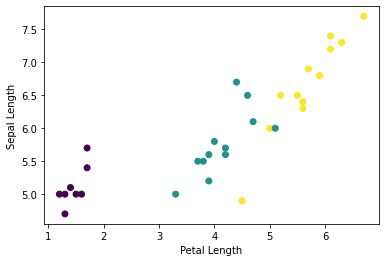

In [11]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c = labels,
            cmap = 'viridis')

plt.xlabel("Petal Length")
plt.ylabel("Sepal Length")

plt.show()

To simplify the model building step, create a function to repackage the features dictionary into a single array with shape (bacth size, numer of features) . This might be one of inifinite ways to deal with problem in TF 


This function uses the tf.stack method which takes values from a list of tensors and creates a combined tensor at the specified dimension.

In [12]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

Then use the tf.data.Dataset.map method to pack the features of each (features, label) paril into the training dataset

In [13]:
train_dataset = train_dataset.map(pack_features_vector)

The features element of the Dataset are now arrays with shape (batch_size, num_features). Let's look at the first few examples:

In [14]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[7.  3.2 4.7 1.4]
 [6.4 2.8 5.6 2.2]
 [6.4 2.8 5.6 2.1]
 [7.7 3.  6.1 2.3]
 [6.6 3.  4.4 1.4]], shape=(5, 4), dtype=float32)


## Modeling using Keras 





In [15]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape = (4,)),
                             tf.keras.layers.Dense(10, activation= tf.nn.relu),
                             tf.keras.layers.Dense(3)
])

## Using The Model 
Let's have a quick look at what this model does to a batch of features

In [16]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ 2.1171813, -2.1998143, -3.5961585],
       [ 2.1087236, -2.2756371, -3.5315363],
       [ 2.0744936, -2.2634358, -3.5134044],
       [ 2.4748647, -2.6393952, -4.121186 ],
       [ 2.0210392, -2.0833743, -3.4090145]], dtype=float32)>

Here, each example returns a logit for each class.

To convert these logits to a probability for each class, use the softmax function:

In [17]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.9836309 , 0.01312154, 0.00324758],
       [0.98422986, 0.01227419, 0.00349593],
       [0.98347133, 0.01284762, 0.00368102],
       [0.9926778 , 0.00596642, 0.00135575],
       [0.9795447 , 0.01616219, 0.00429321]], dtype=float32)>

Taking the tf.argmax across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions:

In [18]:
print("Prediction : {}".format(tf.argmax(predictions, axis =1)))
print("Labels : {}".format(labels))

Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels : [1 2 2 2 1 2 2 1 2 1 0 0 2 0 2 1 0 0 1 0 1 1 1 0 2 0 1 1 0 2 0 0]


## Train the model 

Both training and evaluation stages need to calculate the model's loss. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the tf.keras.losses.SparseCategoricalCrossentropy function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.


In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)


In [20]:
def loss(model, x, y, training):

  y_ = model(x, training = training)
  return loss_object(y_true = y, y_pred = y_)

l = loss(model, features, labels, training = False)
print("Loss test: {}".format(l))

Loss test: 3.1046688556671143


Use the tf.GradientTape context to calculate the gradients used to optimize your model:

In [21]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training = True)

  return loss_value, tape.gradient(loss_value, model.trainable_variables)

## Create an optimizer 

An optimizer applies the computed gradients to the model's variables to minimize the loss function. You can think of the loss function as a curved surface (see Figure 3) and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.


TensorFlow has many optimization algorithms available for training. This model uses the tf.keras.optimizers.SGD that implements the stochastic gradient descent (SGD) algorithm. The learning_rate sets the step size to take for each iteration down the hill. This is a hyperparameter that you'll commonly adjust to achieve better results.

Let's setup the optimizer:

In [22]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [23]:
# we will use this to calculate a single optimization step 

loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables)) # applying optimizer 

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training = True)))


Step: 0, Initial Loss: 3.1046688556671143
Step: 1,         Loss: 2.5537376403808594


## Training Loop 



In [25]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.109, Accuracy: 35.000%
Epoch 050: Loss: 0.571, Accuracy: 71.667%
Epoch 100: Loss: 0.275, Accuracy: 96.667%
Epoch 150: Loss: 0.187, Accuracy: 98.333%
Epoch 200: Loss: 0.132, Accuracy: 98.333%


## Visualizing the training 

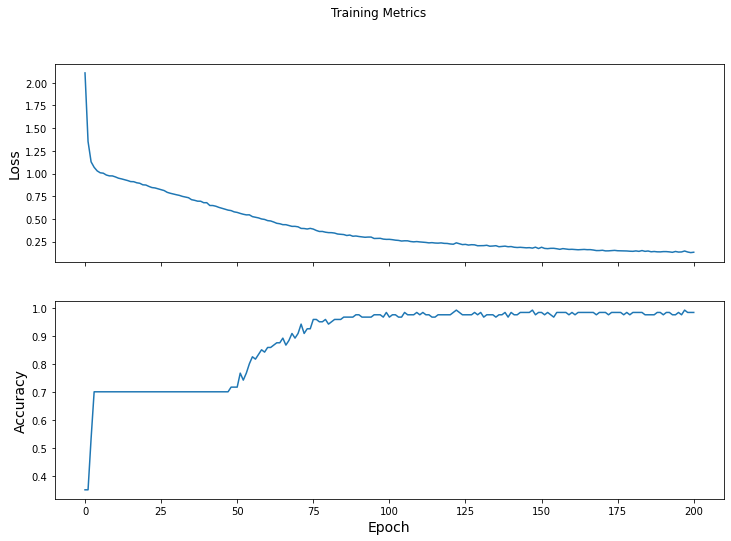

In [31]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## Evaluate model's effectiveness 

In [32]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
test_fp = tf.keras.utils.get_file(fname = os.path.basename(test_url),
                                  origin = test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [33]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names = column_names,
    label_name = 'species',
    num_epochs = 1,
    shuffle = False
)

test_dataset = test_dataset.map(pack_features_vector)

## Evaluate the model on the test data 

Unlike the training stage, the model only evaluates a single epoch of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label. This is used to measure the model's accuracy across the entire test set:

In [34]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x,y) in test_dataset : 
  logits = model(x, training = False)
  prediction = tf.argmax(logits, axis =1, output_type= tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy : {:.3f}".format(test_accuracy.result()))

Test set accuracy : 0.967


We can see the last batch to check how the model performed

In [35]:
tf.stack([y, prediction], axis = 1)

<tf.Tensor: shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

We will check the model again on "Unlabeled" examples.

In [42]:
predict_dataset = tf.convert_to_tensor([
                                        [5.1, 3.3, 1.6, 0.6,],
                                        [5.9, 3.0, 4.2, 1.5,],
                                        [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset, training = False)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction : {} ({:4.1f}%)".format(i ,name, 100*p))

Example 0 prediction : Iris setosa (96.5%)
Example 1 prediction : Iris versicolor (86.1%)
Example 2 prediction : Iris virginica (85.7%)


Thats it. We realize that the inner functionalities and structures are complex than other models. There are lot more to explore, lot more to invent, lot more to trash.